In [1]:
import os
import findspark

os.environ["SPARK_HOME"] = "C:\spark"
findspark.init()

# To display scroll:
from IPython.core.display import HTML
display(HTML("<style>pre { white-space: pre !important; }</style>"))

In [2]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.master('local[*]').appName("Week2").getOrCreate()

spark

In [3]:
path=os.path.abspath('C:\\Users\\Pichau\\Downloads\\dataset_transformado_parquet')

In [4]:
df = spark.read.parquet(path)

In [5]:
df.show(5)

+--------------------+-----+----------+---------+---------+--------------------+-------+------+------------+------------+-----------+----+------------+------------+----------+----+-----+------+
|                  id|andar|area_total|area_util|banheiros|     caracteristicas|quartos|suites|tipo_anuncio|tipo_unidade|   tipo_uso|vaga|      bairro|        zona|condominio|iptu| tipo| valor|
+--------------------+-----+----------+---------+---------+--------------------+-------+------+------------+------------+-----------+----+------------+------------+----------+----+-----+------+
|03a386b6-7ab8-4ef...|    0|        43|       43|        1|[Churrasqueira, A...|      2|  null|       Usado| Apartamento|Residencial|   1|    Realengo|  Zona Oeste|       285|null|Venda| 22999|
|1fe78d41-b8e0-4d2...|    0|        44|       44|        1|                  []|      2|     0|       Usado| Apartamento|Residencial|   0|       Irajá|  Zona Norte|       170|   0|Venda|110000|
|1fa1c1e5-e98c-433...|    4|  

In [6]:
df.printSchema()

root
 |-- id: string (nullable = true)
 |-- andar: long (nullable = true)
 |-- area_total: string (nullable = true)
 |-- area_util: string (nullable = true)
 |-- banheiros: long (nullable = true)
 |-- caracteristicas: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- quartos: long (nullable = true)
 |-- suites: long (nullable = true)
 |-- tipo_anuncio: string (nullable = true)
 |-- tipo_unidade: string (nullable = true)
 |-- tipo_uso: string (nullable = true)
 |-- vaga: long (nullable = true)
 |-- bairro: string (nullable = true)
 |-- zona: string (nullable = true)
 |-- condominio: string (nullable = true)
 |-- iptu: string (nullable = true)
 |-- tipo: string (nullable = true)
 |-- valor: string (nullable = true)



In [7]:
df.count()

66562

# Feature selection
## Select only columns with > 1 distinct value

In [8]:
df = df.drop('id')

In [9]:
import pyspark.sql.functions as f

In [10]:
distinct_values_count = df.select(
    *[f.countDistinct(f.col(colName)).alias(colName) for colName in df.columns]
)

In [11]:
distinct_values_count.show()

+-----+----------+---------+---------+---------------+-------+------+------------+------------+--------+----+------+----+----------+----+----+-----+
|andar|area_total|area_util|banheiros|caracteristicas|quartos|suites|tipo_anuncio|tipo_unidade|tipo_uso|vaga|bairro|zona|condominio|iptu|tipo|valor|
+-----+----------+---------+---------+---------------+-------+------+------------+------------+--------+----+------+----+----------+----+----+-----+
|   53|       695|      592|       18|           6975|     14|    13|           1|           1|       1|  41|   154|   5|      3349|5118|   1| 9753|
+-----+----------+---------+---------+---------------+-------+------+------------+------------+--------+----+------+----+----------+----+----+-----+



In [12]:
columnsToDrop = [col for col,total in distinct_values_count.first().asDict().items() if total == 1]

In [13]:
df_filtered = df.drop(*columnsToDrop)

In [14]:
df_filtered.show(5)

+-----+----------+---------+---------+--------------------+-------+------+----+------------+------------+----------+----+------+
|andar|area_total|area_util|banheiros|     caracteristicas|quartos|suites|vaga|      bairro|        zona|condominio|iptu| valor|
+-----+----------+---------+---------+--------------------+-------+------+----+------------+------------+----------+----+------+
|    0|        43|       43|        1|[Churrasqueira, A...|      2|  null|   1|    Realengo|  Zona Oeste|       285|null| 22999|
|    0|        44|       44|        1|                  []|      2|     0|   0|       Irajá|  Zona Norte|       170|   0|110000|
|    4|      null|       55|        1|                  []|      2|     0|   1|      Cosmos|  Zona Oeste|      null|null|115000|
|    2|      null|       55|        1|                  []|      2|     0|   0|Tomás Coelho|  Zona Norte|      null|null|115000|
|    0|      null|       50|        1|                  []|      1|  null|   0|      Centro|Zona 

## Null values

In [15]:
df_filtered.select([f.count(f.when(f.isnull(c), 1)).alias(c) for c in df_filtered.columns]).show()

+-----+----------+---------+---------+---------------+-------+------+----+------+----+----------+----+-----+
|andar|area_total|area_util|banheiros|caracteristicas|quartos|suites|vaga|bairro|zona|condominio|iptu|valor|
+-----+----------+---------+---------+---------------+-------+------+----+------+----+----------+----+-----+
|    0|      9194|        0|        0|              0|      0|  5554|3017|     0|   0|      2371|7199|    0|
+-----+----------+---------+---------+---------------+-------+------+----+------+----+----------+----+-----+



In [16]:
df_filtered_zero_fill = df_filtered.select(
     *[f.when(f.col(colName).isNull(), 0).otherwise(f.col(colName)).alias(colName)\
       if colName in ['area_total','suites','vaga','condominio','iptu']\
       else f.col(colName)\
       for colName in df_filtered.columns]
)

In [17]:
df_filtered_zero_fill.select([f.count(f.when(f.isnull(c), 1)).alias(c) for c in df_filtered.columns]).show()

+-----+----------+---------+---------+---------------+-------+------+----+------+----+----------+----+-----+
|andar|area_total|area_util|banheiros|caracteristicas|quartos|suites|vaga|bairro|zona|condominio|iptu|valor|
+-----+----------+---------+---------+---------------+-------+------+----+------+----+----------+----+-----+
|    0|         0|        0|        0|              0|      0|     0|   0|     0|   0|         0|   0|    0|
+-----+----------+---------+---------+---------------+-------+------+----+------+----+----------+----+-----+



In [18]:
df_filtered_zero_fill.show(5)

+-----+----------+---------+---------+--------------------+-------+------+----+------------+------------+----------+----+------+
|andar|area_total|area_util|banheiros|     caracteristicas|quartos|suites|vaga|      bairro|        zona|condominio|iptu| valor|
+-----+----------+---------+---------+--------------------+-------+------+----+------------+------------+----------+----+------+
|    0|        43|       43|        1|[Churrasqueira, A...|      2|     0|   1|    Realengo|  Zona Oeste|       285|   0| 22999|
|    0|        44|       44|        1|                  []|      2|     0|   0|       Irajá|  Zona Norte|       170|   0|110000|
|    4|         0|       55|        1|                  []|      2|     0|   1|      Cosmos|  Zona Oeste|         0|   0|115000|
|    2|         0|       55|        1|                  []|      2|     0|   0|Tomás Coelho|  Zona Norte|         0|   0|115000|
|    0|         0|       50|        1|                  []|      1|     0|   0|      Centro|Zona 

## Type conversion

In [19]:
df.printSchema()

root
 |-- andar: long (nullable = true)
 |-- area_total: string (nullable = true)
 |-- area_util: string (nullable = true)
 |-- banheiros: long (nullable = true)
 |-- caracteristicas: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- quartos: long (nullable = true)
 |-- suites: long (nullable = true)
 |-- tipo_anuncio: string (nullable = true)
 |-- tipo_unidade: string (nullable = true)
 |-- tipo_uso: string (nullable = true)
 |-- vaga: long (nullable = true)
 |-- bairro: string (nullable = true)
 |-- zona: string (nullable = true)
 |-- condominio: string (nullable = true)
 |-- iptu: string (nullable = true)
 |-- tipo: string (nullable = true)
 |-- valor: string (nullable = true)



In [20]:
from pyspark.sql.types import IntegerType, DoubleType

In [21]:
df_type_corrected = df_filtered_zero_fill\
    .withColumn('andar', df_filtered_zero_fill['andar'].cast(IntegerType()))\
    .withColumn('area_total', df_filtered_zero_fill['area_total'].cast(IntegerType()))\
    .withColumn('area_util', df_filtered_zero_fill['area_util'].cast(IntegerType()))\
    .withColumn('banheiros', df_filtered_zero_fill['banheiros'].cast(IntegerType()))\
    .withColumn('quartos', df_filtered_zero_fill['quartos'].cast(IntegerType()))\
    .withColumn('suites', df_filtered_zero_fill['suites'].cast(IntegerType()))\
    .withColumn('vaga', df_filtered_zero_fill['vaga'].cast(IntegerType()))\
    .withColumn('condominio', df_filtered_zero_fill['condominio'].cast(IntegerType()))\
    .withColumn('iptu', df_filtered_zero_fill['iptu'].cast(IntegerType()))\
    .withColumn('valor', df_filtered_zero_fill['valor'].cast(IntegerType()))

In [22]:
df_type_corrected = df_filtered_zero_fill.withColumns({col: f.col(col).cast(IntegerType()) for col in ['andar','banheiros','quartos','suites','vaga']})
df_type_corrected = df_filtered_zero_fill.withColumns({col: f.col(col).cast(DoubleType()) for col in ['area_total','area_util','condominio','iptu','valor']})

In [23]:
df_type_corrected.printSchema()
df_type_corrected.show(5)

root
 |-- andar: long (nullable = true)
 |-- area_total: double (nullable = true)
 |-- area_util: double (nullable = true)
 |-- banheiros: long (nullable = true)
 |-- caracteristicas: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- quartos: long (nullable = true)
 |-- suites: long (nullable = true)
 |-- vaga: long (nullable = true)
 |-- bairro: string (nullable = true)
 |-- zona: string (nullable = true)
 |-- condominio: double (nullable = true)
 |-- iptu: double (nullable = true)
 |-- valor: double (nullable = true)

+-----+----------+---------+---------+--------------------+-------+------+----+------------+------------+----------+------+--------+
|andar|area_total|area_util|banheiros|     caracteristicas|quartos|suites|vaga|      bairro|        zona|condominio|  iptu|   valor|
+-----+----------+---------+---------+--------------------+-------+------+----+------------+------------+----------+------+--------+
|    0|      43.0|     43.0|        1|[Churrasqu

## Analyze columns

In [24]:
import matplotlib.pyplot as plt

In [25]:
df_pd = df_type_corrected.toPandas()

In [26]:
df_pd.head()

,andar,area_total,area_util,banheiros,caracteristicas,quartos,suites,vaga,bairro,zona,condominio,iptu,valor
0,0,43.0,43.0,1,"[Churrasqueira, Academia, Playground, Salão de...",2,0,1,Realengo,Zona Oeste,285.0,0.0,22999.0
1,0,44.0,44.0,1,[],2,0,0,Irajá,Zona Norte,170.0,0.0,110000.0
2,4,0.0,55.0,1,[],2,0,1,Cosmos,Zona Oeste,0.0,0.0,115000.0
3,2,0.0,55.0,1,[],2,0,0,Tomás Coelho,Zona Norte,0.0,0.0,115000.0
4,0,0.0,50.0,1,[],1,0,0,Centro,Zona Central,1300.0,2679.0,125000.0


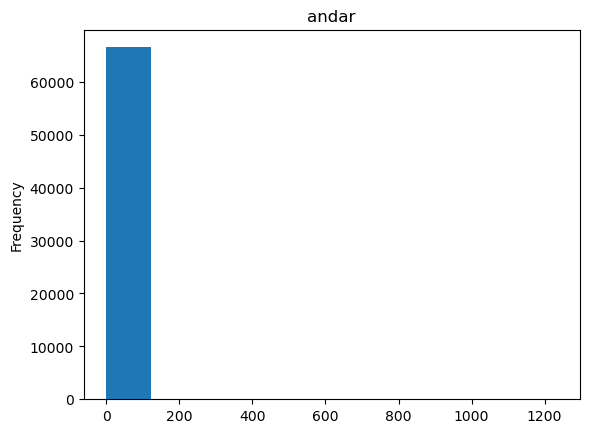

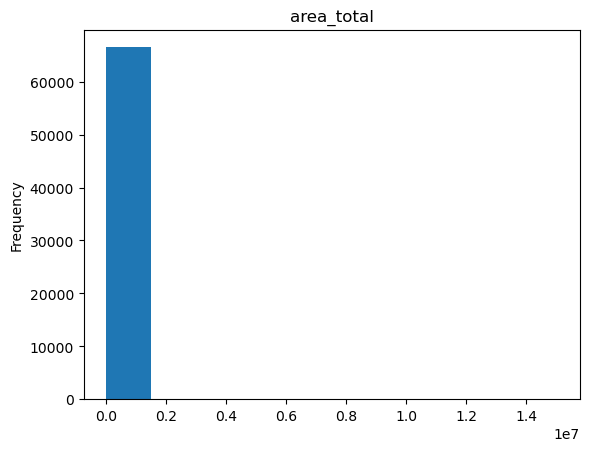

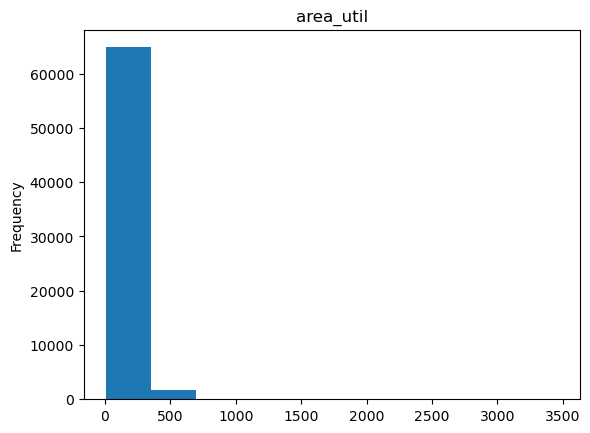

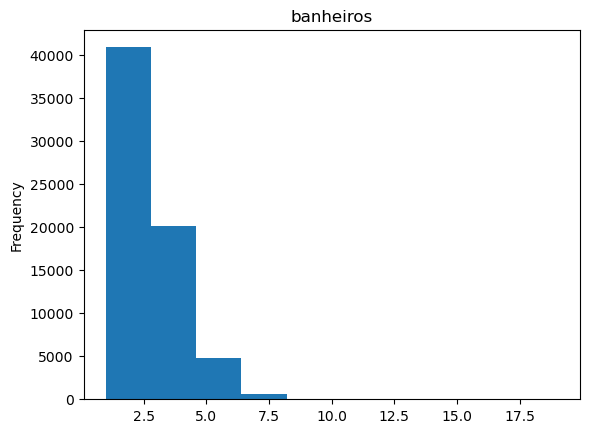

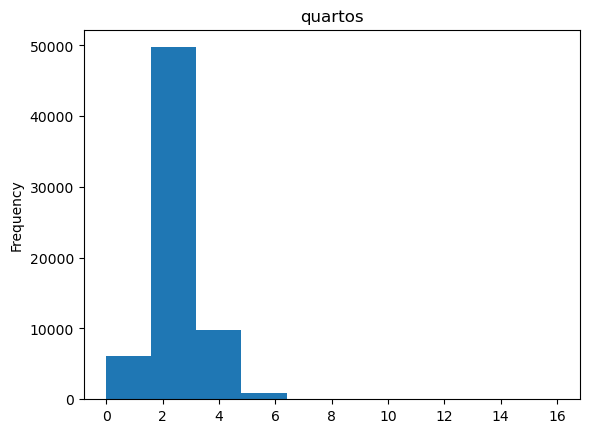

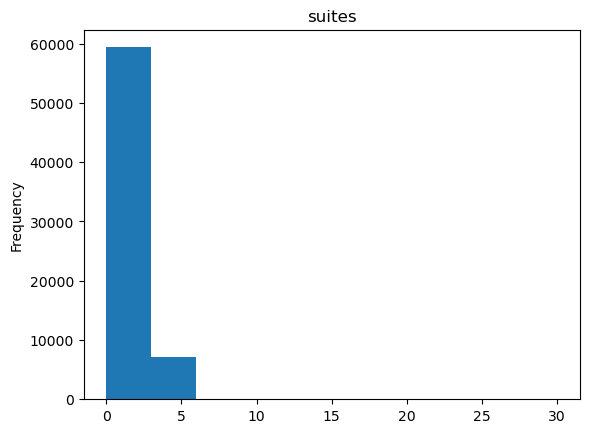

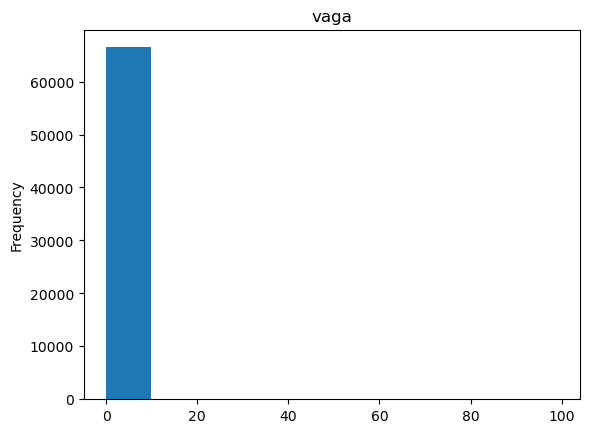

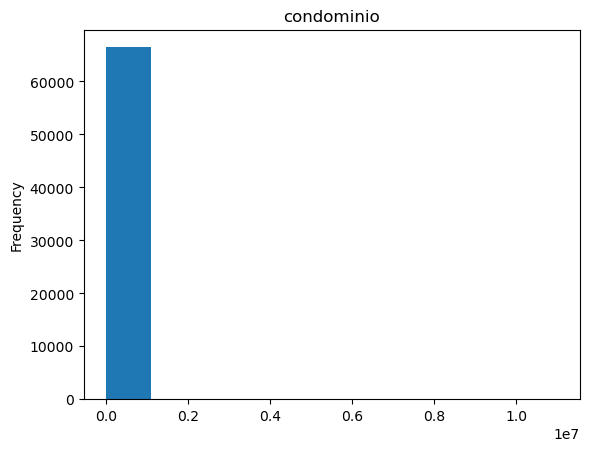

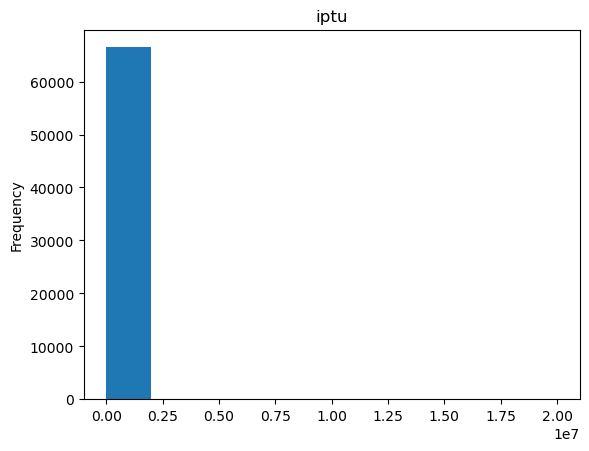

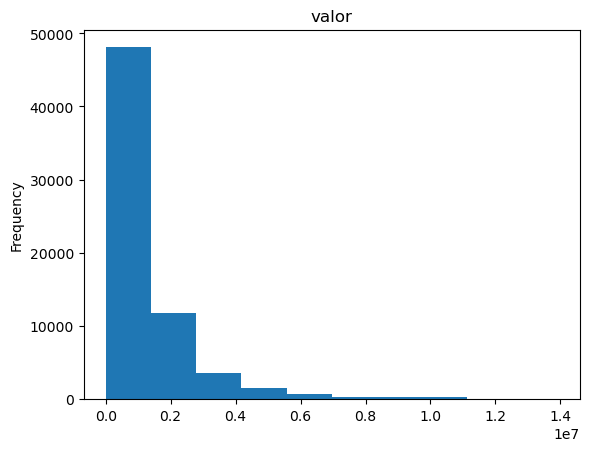

In [27]:
for col in ['andar','area_total','area_util','banheiros','quartos','suites','vaga','condominio','iptu','valor']:
    plt.figure()
    plt.title(col)
    df_pd[col].plot(kind='hist') 

<Axes: title={'center': 'zona'}, xlabel='zona'>

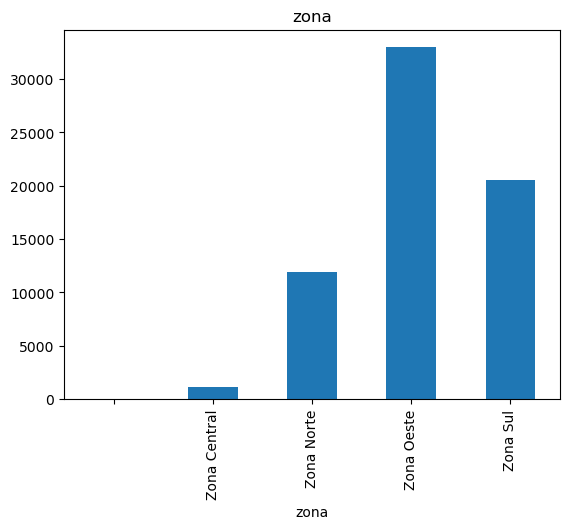

In [28]:
plt.figure()
plt.title('zona')
df_pd.groupby('zona').size().plot(kind='bar')

# Empty List to Null

In [29]:
df_type_corrected.show(5)

+-----+----------+---------+---------+--------------------+-------+------+----+------------+------------+----------+------+--------+
|andar|area_total|area_util|banheiros|     caracteristicas|quartos|suites|vaga|      bairro|        zona|condominio|  iptu|   valor|
+-----+----------+---------+---------+--------------------+-------+------+----+------------+------------+----------+------+--------+
|    0|      43.0|     43.0|        1|[Churrasqueira, A...|      2|     0|   1|    Realengo|  Zona Oeste|     285.0|   0.0| 22999.0|
|    0|      44.0|     44.0|        1|                  []|      2|     0|   0|       Irajá|  Zona Norte|     170.0|   0.0|110000.0|
|    4|       0.0|     55.0|        1|                  []|      2|     0|   1|      Cosmos|  Zona Oeste|       0.0|   0.0|115000.0|
|    2|       0.0|     55.0|        1|                  []|      2|     0|   0|Tomás Coelho|  Zona Norte|       0.0|   0.0|115000.0|
|    0|       0.0|     50.0|        1|                  []|      1|  

In [30]:
df_type_corrected = df_type_corrected\
    .withColumn('caracteristicas', f.when(f.size('caracteristicas') == 0, None).otherwise(f.col('caracteristicas')))

In [31]:
df_type_corrected.show(5)

+-----+----------+---------+---------+--------------------+-------+------+----+------------+------------+----------+------+--------+
|andar|area_total|area_util|banheiros|     caracteristicas|quartos|suites|vaga|      bairro|        zona|condominio|  iptu|   valor|
+-----+----------+---------+---------+--------------------+-------+------+----+------------+------------+----------+------+--------+
|    0|      43.0|     43.0|        1|[Churrasqueira, A...|      2|     0|   1|    Realengo|  Zona Oeste|     285.0|   0.0| 22999.0|
|    0|      44.0|     44.0|        1|                null|      2|     0|   0|       Irajá|  Zona Norte|     170.0|   0.0|110000.0|
|    4|       0.0|     55.0|        1|                null|      2|     0|   1|      Cosmos|  Zona Oeste|       0.0|   0.0|115000.0|
|    2|       0.0|     55.0|        1|                null|      2|     0|   0|Tomás Coelho|  Zona Norte|       0.0|   0.0|115000.0|
|    0|       0.0|     50.0|        1|                null|      1|  

# Dummy Variables

In [32]:
df_type_corrected = df_type_corrected.withColumn("id", f.monotonically_increasing_id())

In [33]:
df_type_corrected.show(5)

+-----+----------+---------+---------+--------------------+-------+------+----+------------+------------+----------+------+--------+---+
|andar|area_total|area_util|banheiros|     caracteristicas|quartos|suites|vaga|      bairro|        zona|condominio|  iptu|   valor| id|
+-----+----------+---------+---------+--------------------+-------+------+----+------------+------------+----------+------+--------+---+
|    0|      43.0|     43.0|        1|[Churrasqueira, A...|      2|     0|   1|    Realengo|  Zona Oeste|     285.0|   0.0| 22999.0|  0|
|    0|      44.0|     44.0|        1|                null|      2|     0|   0|       Irajá|  Zona Norte|     170.0|   0.0|110000.0|  1|
|    4|       0.0|     55.0|        1|                null|      2|     0|   1|      Cosmos|  Zona Oeste|       0.0|   0.0|115000.0|  2|
|    2|       0.0|     55.0|        1|                null|      2|     0|   0|Tomás Coelho|  Zona Norte|       0.0|   0.0|115000.0|  3|
|    0|       0.0|     50.0|        1|   

In [34]:
zona = df_type_corrected\
    .groupBy('id')\
    .pivot('zona')\
    .agg(f.lit(1))\
    .na.fill(0)
zona.show(5)

+-----+---+------------+----------+----------+--------+
|   id|   |Zona Central|Zona Norte|Zona Oeste|Zona Sul|
+-----+---+------------+----------+----------+--------+
|40395|  0|           0|         0|         1|       0|
|15432|  0|           0|         1|         0|       0|
|64442|  0|           0|         1|         0|       0|
|18628|  0|           0|         0|         1|       0|
|25479|  0|           0|         1|         0|       0|
+-----+---+------------+----------+----------+--------+
only showing top 5 rows



In [35]:
bairro = df_type_corrected\
    .groupBy('id')\
    .pivot('bairro')\
    .agg(f.lit(1))\
    .na.fill(0)
bairro.show(5)

+-----+--------+-----------------+--------+-------+----+---------+-----+---------------+------------------+------------+-------+-------------+-------------+----------+--------+------------+--------+------+----+-------+--------+------------+-----------------+---------+------+-------+----------+------+-----------+--------------+------+-----------+-------+----------+--------+-----------+------+--------+------------+-------+---------+---------------+------------+-----------------+-----------------+----------------+-------+--------+------------------------------+-----------------------+------+------+-------------+------+------+----------+---------+---------+-----+------------+--------------+-------+-------+--------+-------+-----+---------+-----------+------+--------------+---------------+--------------+----------------+--------------+---+-----+-----------+------+----+-------------------+---------+----------------+---------+----------+--------+---------------+--------------+------+-----+----

In [36]:
caracteristicas = df_type_corrected\
    .withColumn('caracteristicas', f.explode('caracteristicas'))\
    .groupBy('id')\
    .pivot('caracteristicas')\
    .agg(f.lit(1))\
    .na.fill(0)
caracteristicas.show(5)
caracteristicas.count()

+-----+--------+------------------+-------------+------------------+--------+-------+----------+------------+-----------------+---------------+
|   id|Academia|Animais permitidos|Churrasqueira|Condomínio fechado|Elevador|Piscina|Playground|Portaria 24h|Portão eletrônico|Salão de festas|
+-----+--------+------------------+-------------+------------------+--------+-------+----------+------------+-----------------+---------------+
| 2453|       0|                 1|            0|                 1|       1|      0|         0|           1|                1|              0|
|13460|       1|                 1|            1|                 1|       1|      1|         1|           1|                1|              1|
|15173|       1|                 1|            1|                 1|       1|      1|         1|           1|                0|              1|
|15194|       1|                 0|            1|                 0|       1|      1|         1|           0|                0|         

53826

In [37]:
caracteristicas_cols = [col for col in caracteristicas.columns if col != 'id']
caracteristicas_cols

['Academia',
 'Animais permitidos',
 'Churrasqueira',
 'Condomínio fechado',
 'Elevador',
 'Piscina',
 'Playground',
 'Portaria 24h',
 'Portão eletrônico',
 'Salão de festas']

In [38]:
df_merged = df_type_corrected.join(caracteristicas, 'id', how='left')
df_merged.show(5)

+---+-----+----------+---------+---------+--------------------+-------+------+----+------------+------------+----------+------+--------+--------+------------------+-------------+------------------+--------+-------+----------+------------+-----------------+---------------+
| id|andar|area_total|area_util|banheiros|     caracteristicas|quartos|suites|vaga|      bairro|        zona|condominio|  iptu|   valor|Academia|Animais permitidos|Churrasqueira|Condomínio fechado|Elevador|Piscina|Playground|Portaria 24h|Portão eletrônico|Salão de festas|
+---+-----+----------+---------+---------+--------------------+-------+------+----+------------+------------+----------+------+--------+--------+------------------+-------------+------------------+--------+-------+----------+------------+-----------------+---------------+
|  0|    0|      43.0|     43.0|        1|[Churrasqueira, A...|      2|     0|   1|    Realengo|  Zona Oeste|     285.0|   0.0| 22999.0|       1|                 1|            1|   

In [39]:
df_merged = df_merged.select(
     *[f.when(f.col(colName).isNull(), 0).otherwise(f.col(colName)).alias(colName)\
       if colName in caracteristicas_cols\
       else f.col(colName)\
       for colName in df_merged.columns]
)
df_merged.show(5)

+---+-----+----------+---------+---------+--------------------+-------+------+----+------------+------------+----------+------+--------+--------+------------------+-------------+------------------+--------+-------+----------+------------+-----------------+---------------+
| id|andar|area_total|area_util|banheiros|     caracteristicas|quartos|suites|vaga|      bairro|        zona|condominio|  iptu|   valor|Academia|Animais permitidos|Churrasqueira|Condomínio fechado|Elevador|Piscina|Playground|Portaria 24h|Portão eletrônico|Salão de festas|
+---+-----+----------+---------+---------+--------------------+-------+------+----+------------+------------+----------+------+--------+--------+------------------+-------------+------------------+--------+-------+----------+------------+-----------------+---------------+
|  0|    0|      43.0|     43.0|        1|[Churrasqueira, A...|      2|     0|   1|    Realengo|  Zona Oeste|     285.0|   0.0| 22999.0|       1|                 1|            1|   

In [40]:
df_merged = df_merged.join(zona, 'id', how='inner')
df_merged = df_merged.join(bairro, 'id', how='inner')
df_merged.show(5)
df_merged.count()
df_type_corrected.count()

+---+-----+----------+---------+---------+--------------------+-------+------+----+------------+------------+----------+------+--------+--------+------------------+-------------+------------------+--------+-------+----------+------------+-----------------+---------------+---+------------+----------+----------+--------+--------+-----------------+--------+-------+----+---------+-----+---------------+------------------+------------+-------+-------------+-------------+----------+--------+------------+--------+------+----+-------+--------+------------+-----------------+---------+------+-------+----------+------+-----------+--------------+------+-----------+-------+----------+--------+-----------+------+--------+------------+-------+---------+---------------+------------+-----------------+-----------------+----------------+-------+--------+------------------------------+-----------------------+------+------+-------------+------+------+----------+---------+---------+-----+------------+-------

66562

In [43]:
df_final = df_merged.drop('id','caracteristicas','bairro','zona')

In [44]:
df_final.show(5)

+-----+----------+---------+---------+-------+------+----+----------+------+--------+--------+------------------+-------------+------------------+--------+-------+----------+------------+-----------------+---------------+---+------------+----------+----------+--------+--------+-----------------+--------+-------+----+---------+-----+---------------+------------------+------------+-------+-------------+-------------+----------+--------+------------+--------+------+----+-------+--------+------------+-----------------+---------+------+-------+----------+------+-----------+--------------+------+-----------+-------+----------+--------+-----------+------+--------+------------+-------+---------+---------------+------------+-----------------+-----------------+----------------+-------+--------+------------------------------+-----------------------+------+------+-------------+------+------+----------+---------+---------+-----+------------+--------------+-------+-------+--------+-------+-----+----

In [48]:
columnsToDrop = [col for col in df_final.columns if col.strip() == ""]
columnsToDrop

['']

In [49]:
df_final = df_final.drop(*columnsToDrop)

In [82]:
df_final.write.parquet('C:\\Users\\Pichau\\Downloads\\dataset_final_parquet\\df_final.parquet')

# Correlation

In [6]:
from pyspark.ml.feature import VectorAssembler

In [46]:
df_final = df_final.withColumnRenamed('valor','label')

In [69]:
X = [col for col in df_final.columns[:df_final.columns.index('Abolição')] if col != 'label']

In [70]:
X

['andar',
 'area_total',
 'area_util',
 'banheiros',
 'quartos',
 'suites',
 'vaga',
 'condominio',
 'iptu',
 'Academia',
 'Animais permitidos',
 'Churrasqueira',
 'Condomínio fechado',
 'Elevador',
 'Piscina',
 'Playground',
 'Portaria 24h',
 'Portão eletrônico',
 'Salão de festas',
 'Zona Central',
 'Zona Norte',
 'Zona Oeste',
 'Zona Sul']

In [71]:
assembler = VectorAssembler(inputCols = X, outputCol = 'features')

In [72]:
dataset_prep = assembler.transform(df_final).select('features','label')

In [73]:
dataset_prep.show(10, truncate=False)

+-------------------------------------------------------------------------------------------------------+--------+
|features                                                                                               |label   |
+-------------------------------------------------------------------------------------------------------+--------+
|[0.0,43.0,43.0,1.0,2.0,0.0,1.0,285.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0]      |22999.0 |
|(23,[1,2,3,4,7,20],[44.0,44.0,1.0,2.0,170.0,1.0])                                                      |110000.0|
|(23,[0,2,3,4,6,21],[4.0,55.0,1.0,2.0,1.0,1.0])                                                         |115000.0|
|(23,[0,2,3,4,20],[2.0,55.0,1.0,2.0,1.0])                                                               |115000.0|
|(23,[2,3,4,7,8,19],[50.0,1.0,1.0,1300.0,2679.0,1.0])                                                   |125000.0|
|(23,[0,1,2,3,4,6,7,10,11,12,14,16,18,21],[2.0,47.0,47.0,1.0,2.0,1.0,380.0,1.0,1

In [74]:
from pyspark.ml.stat import Correlation
import pandas as pd

In [75]:
correlacao = Correlation.corr(dataset_prep, 'features').collect()[0][0]

In [76]:
df_correlacao = pd.DataFrame(correlacao.toArray(), columns=X, index=X)

In [77]:
import matplotlib.pyplot as plt
import seaborn as sns

<Axes: >

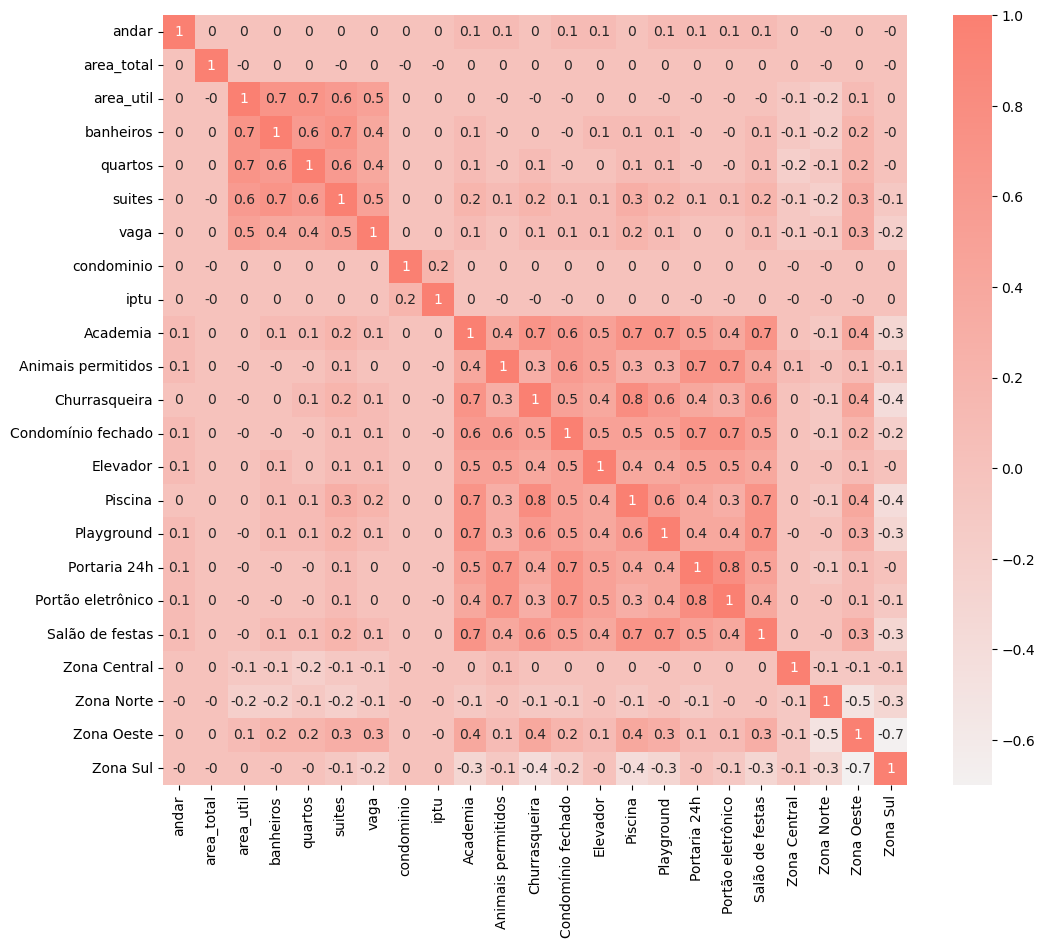

In [78]:
plt.figure(figsize=(12,10))
paleta = sns.color_palette("light:salmon", as_cmap=True)
sns.heatmap(df_correlacao.round(1), annot=True, cmap=paleta)

# Data Preparation

In [84]:
df_final = spark.read.parquet('C:\\Users\\Pichau\\Downloads\\dataset_final_parquet\\df_final.parquet')
df_final = df_final.withColumnRenamed('valor','label')

In [85]:
X = [col for col in df_final.columns if col != 'label']

In [86]:
assembler = VectorAssembler(inputCols = X, outputCol = 'features')

In [87]:
dataset_prep = assembler.transform(df_final).select('features','label')

# Linear Regression

In [88]:
from pyspark.ml.regression import LinearRegression

In [100]:
train, test = dataset_prep.randomSplit([0.7,0.3], seed=101)

In [101]:
train.count()

46510

In [102]:
test.count()

20052

In [103]:
def train_and_evaluate_LR(train, test):
    lr = LinearRegression()
    lr_model = lr.fit(train)
    evaluation = lr_model.evaluate(test)
    print('Linear Regression')
    print('='*30)
    print('R²: %f' % evaluation.r2)
    print('RMSE: %f' % evaluation.rootMeanSquaredError)
    print("")
    print('='*30)

In [104]:
train_and_evaluate_LR(train, test)

Linear Regression
R²: 0.724022
RMSE: 776372.744504



# Decision Tree

In [9]:
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.evaluation import RegressionEvaluator

In [10]:
def train_and_evaluate_tree(model, train, test):
    dt_model = model.fit(train)
    evaluator = RegressionEvaluator()
    test_predictions = dt_model.transform(test)
    print('Tree')
    print('='*30)
    print('R²: %f' % evaluator.evaluate(test_predictions, {evaluator.metricName: "r2"}))
    print('RMSE: %f' % evaluator.evaluate(test_predictions, {evaluator.metricName: "rmse"}))
    print("")
    print('='*30)

In [110]:
dt = DecisionTreeRegressor(seed=101, maxDepth=7)
train_and_evaluate_tree(dt, train, test)

Tree
R²: 0.802763
RMSE: 656337.800901



# Random Forest

In [11]:
from pyspark.ml.regression import RandomForestRegressor

In [113]:
random_forest = RandomForestRegressor(seed=101, maxDepth=7, numTrees=10)
train_and_evaluate_tree(random_forest, train, test)

Tree
R²: 0.815450
RMSE: 634878.197518



# Cross Validation

In [17]:
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator

In [115]:
random_forest = RandomForestRegressor()
grid = ParamGridBuilder() \
    .addGrid(random_forest.numTrees, [10, 20, 30]) \
    .addGrid(random_forest.maxDepth, [5, 10]) \
    .addGrid(random_forest.maxBins, [10, 32, 45]) \
    .build()

In [19]:
def train_and_evaluate_tree_cv(model, train, test):
    evaluator = RegressionEvaluator()
    cv = CrossValidator(
        estimator=model,
        estimatorParamMaps=grid,
        evaluator=evaluator,
        numFolds=3
    )
    dt_model = cv.fit(train)
    test_predictions = dt_model.transform(test)
    print('Tree')
    print('='*30)
    print('R²: %f' % evaluator.evaluate(test_predictions, {evaluator.metricName: "r2"}))
    print('RMSE: %f' % evaluator.evaluate(test_predictions, {evaluator.metricName: "rmse"}))
    print("")
    print('='*30)

In [117]:
train_and_evaluate_tree_cv(random_forest, train, test)

Tree
R²: 0.861256
RMSE: 550477.997003



# Select features

In [3]:
df_final = spark.read.parquet('C:\\Users\\Pichau\\Downloads\\dataset_final_parquet\\df_final.parquet')
df_final = df_final.withColumnRenamed('valor','label')

In [21]:
X = [col for col in df_final.columns if col not in ['label','area_total']]

In [22]:
def get_train_test(df, X):
    assembler = VectorAssembler(inputCols = X, outputCol = 'features')
    dataset_prep = assembler.transform(df_final).select('features','label')
    return dataset_prep.randomSplit([0.7,0.3], seed=101)

In [23]:
train, test = get_train_test(df_final, X)

In [12]:
random_forest = RandomForestRegressor(seed=101, maxDepth=7, numTrees=10)
train_and_evaluate_tree(random_forest, train, test)

Tree
R²: 0.827035
RMSE: 618240.354864



In [24]:
random_forest = RandomForestRegressor()
grid = ParamGridBuilder() \
    .addGrid(random_forest.numTrees, [5, 10, 20]) \
    .addGrid(random_forest.maxDepth, [5, 10, 15]) \
    .addGrid(random_forest.maxBins, [10, 20, 30]) \
    .build()

In [25]:
train_and_evaluate_tree_cv(random_forest, train, test)

Tree
R²: 0.865468
RMSE: 545243.183284

